# Usher trees and metadata

This notebook explores data available [from the usher team](http://hgdownload.soe.ucsc.edu/goldenPath/wuhCor1/UShER_SARS-CoV-2/). Before running this notebook, run
```sh
scripts/pull_usher.sh  # takes <1 minute
```

In [26]:
import os
import pickle
from collections import Counter, defaultdict
import pandas as pd
import torch
import matplotlib
import matplotlib.pyplot as plt

matplotlib.rcParams["figure.dpi"] = 200
matplotlib.rcParams["axes.edgecolor"] = "gray"
matplotlib.rcParams["figure.facecolor"] = "white"

In [2]:
df = pd.read_csv("results/usher/metadata.tsv", sep="\t", dtype=str)
df

,strain,genbank_accession,date,country,host,completeness,length,Nextstrain_clade,pangolin_lineage,Nextstrain_clade_usher,pango_lineage_usher
0,100002|LR824035.1|2020-03-05,LR824035.1,2020-03-05,Switzerland,Homo sapiens,NaN,29903,20A,B.1,20A,B.1
1,100003|LR824038.1|2020-03-04,LR824038.1,2020-03-04,Switzerland,Homo sapiens,NaN,29903,20B,B.1.1,20B,B.1.1
2,100004|LR824040.1|2020-03-06,LR824040.1,2020-03-06,Switzerland,Homo sapiens,NaN,29903,20A,B.1,20A,B.1
3,100005|LR824037.1|2020-03-06,LR824037.1,2020-03-06,Switzerland,Homo sapiens,NaN,29903,20A,B.1,20A,B.1
4,100006|LR824041.1|2020-03-06,LR824041.1,2020-03-06,Switzerland,Homo sapiens,NaN,29903,20A,B.1,20A,B.1
...,...,...,...,...,...,...,...,...,...,...,...
3559016,tiger/USA/Tiger3-VA/2021|MZ305031.1|2021-04-13,MZ305031.1,2021-04-13,USA,Panthera tigris,NaN,29712,"20I (Alpha, V1)",B.1.1.7,"20I (Alpha,V1)",B.1.1.7
3559017,tiger/USA/tiger-2-040420/2020|MT704313.1|2020-...,MT704313.1,2020-04-04,USA,Panthera tigris,NaN,29872,20C,B.1,20C,B.1
3559018,tiger/USA/tiger-3-040420/2020|MT704315.1|2020-...,MT704315.1,2020-04-04,USA,Panthera tigris,NaN,29863,20C,B.1,20C,B.1
3559019,tiger/USA/tiger-4-040420/2020|MT704316.1|2020-...,MT704316.1,2020-04-04,USA,Panthera tigris,NaN,29834,20C,B.1,20C,B.1


In [3]:
df2 = pd.read_csv("results/nextstrain/metadata.tsv", sep="\t", dtype=str)
df2

,strain,virus,gisaid_epi_isl,genbank_accession,sra_accession,date,region,country,division,location,...,QC_mixed_sites,QC_rare_mutations,QC_snp_clusters,QC_frame_shifts,QC_stop_codons,frame_shifts,insertions,substitutions,aaSubstitutions,clock_deviation
0,?,ncov,EPI_ISL_1333564,OU089159,ERR5536607,?,Europe,United Kingdom,?,NaN,...,good,good,good,NaN,NaN,NaN,23584:CAGACT,"T1947C,C3037T,C3587T,C3927T,A8081C,C14408T,G15...","ORF1a:V561A,ORF1a:H1108Y,ORF1a:S1221L,ORF1a:M2...",?
1,ARG/Cordoba-1006-155/2020,ncov,?,MW553298,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,good,NaN,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",4.0
2,ARG/Cordoba-1083-6/2020,ncov,?,MW553296,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,good,NaN,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",5.0
3,ARG/Cordoba-11300-61/2020,ncov,?,MW553301,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,good,NaN,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",2.0
4,ARG/Cordoba-11301-61/2020,ncov,?,MW553314,NaN,2020-06-04,South America,Argentina,Argentina,NaN,...,good,good,good,NaN,NaN,NaN,NaN,"C241T,C3037T,C3261T,C9711T,C14408T,C17012T,A20...","ORF1a:T999I,ORF1a:S3149F,ORF1b:P314L,ORF1b:S11...",4.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3244157,mink/USA/WI-CDC-3892924-001/2020,ncov,?,MW626382,NaN,2020-10-15,North America,USA,USA,NaN,...,good,good,good,ORF6:23-62,NaN,ORF6:23-62,NaN,"C241T,C1059T,C3037T,A5877G,A10875G,T11968C,C14...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:N1871S,ORF1a...",-1.0
3244158,mink/USA/WI-CDC-3892928-001/2020,ncov,EPI_ISL_1014952,MW626383,NaN,2020-10-15,North America,USA,USA,NaN,...,good,good,good,NaN,NaN,NaN,NaN,"C241T,C1059T,C3037T,A5877G,A10875G,T11968C,C14...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:N1871S,ORF1a...",-1.0
3244159,mink/USA/WI-CDC-3892938-001/2020,ncov,EPI_ISL_1014953,MW626384,NaN,2020-10-15,North America,USA,USA,NaN,...,good,good,good,NaN,NaN,NaN,NaN,"C241T,C1059T,C2675T,C3037T,A5877G,A10875G,T119...","N:S194L,N:K355N,ORF1a:T265I,ORF1a:P804S,ORF1a:...",1.0
3244160,mouse/CHN/MP7/2021,ncov,?,OM062573,NaN,2021-05-01,Asia,China,Beijing,NaN,...,good,good,good,NaN,NaN,NaN,NaN,"T3C,G174T,C241T,C1059T,A2692T,C3037T,C3817T,C3...","E:T30I,E:P71L,N:T205I,ORF1a:T265I,ORF1a:P1220L...",0.0


In [17]:
df2.columns

Index(['strain', 'virus', 'gisaid_epi_isl', 'genbank_accession',
       'sra_accession', 'date', 'region', 'country', 'division', 'location',
       'region_exposure', 'country_exposure', 'division_exposure', 'segment',
       'length', 'host', 'age', 'sex', 'Nextstrain_clade', 'pango_lineage',
       'GISAID_clade', 'originating_lab', 'submitting_lab', 'authors', 'url',
       'title', 'paper_url', 'date_submitted', 'sampling_strategy',
       'missing_data', 'divergence', 'nonACGTN', 'rare_mutations',
       'QC_missing_data', 'QC_mixed_sites', 'QC_rare_mutations',
       'QC_snp_clusters', 'QC_frame_shifts', 'QC_stop_codons', 'frame_shifts',
       'insertions', 'substitutions', 'aaSubstitutions', 'clock_deviation'],
      dtype='object')

In [4]:
l = df["genbank_accession"].tolist()
print(repr(l[:8]))

['LR824035.1', 'LR824038.1', 'LR824040.1', 'LR824037.1', 'LR824041.1', 'LR824039.1', 'LR824042.1', 'LR824046.1']


In [5]:
ids1 = set(df["genbank_accession"].tolist())

In [6]:
ids2 = set(df2["genbank_accession"].tolist())

In [7]:
print(len(ids1), len(ids2))
print(len(ids1 & ids2), len(ids1 - ids2), len(ids2 - ids1))

2977158 3244162
0 2977158 3244162


In [9]:
ids12 = {i.split(".")[0] for i in ids1 if isinstance(i, str)}
print(len(ids12 & ids2), len(ids12 - ids2), len(ids2 - ids12))

2923985 53088 320177


In [10]:
ids21 = {i + ".1" for i in ids2}
print(len(ids1 & ids21), len(ids1 - ids21), len(ids21 - ids1))

2919897 57261 324265


In [11]:
Counter(i.split(".", 1)[1] for i in ids1 if isinstance(i, str))

Counter({'1': 2972985, '2': 4054, '3': 107, '4': 11})

In [13]:
versions = defaultdict(set)
for i in ids1:
    if isinstance(i, str):
        lhs, rhs = i.split(".")
        versions[lhs].add(rhs)
Counter(map(len, versions.values()))

Counter({1: 2976989, 2: 84})

In [57]:
dates = df2["date"].tolist()
Counter(map(len, dates))

Counter({1: 707, 10: 3212871, 4: 22166, 7: 8418})

In [67]:
# Copied from scripts/preprocess_usher.py
import datetime
from pyrocov.mutrans import START_DATE
DATE_FORMATS = {7: "%Y-%m", 10: "%Y-%m-%d"}

def try_parse_date(string):
    fmt = DATE_FORMATS.get(len(string))
    if fmt is not None:
        return datetime.datetime.strptime(string, fmt)

In [68]:
start_date = try_parse_date(START_DATE)
days = Counter()
for string in dates:
    date = try_parse_date(string)
    if date is not None:
        days[(date - start_date).days] += 1

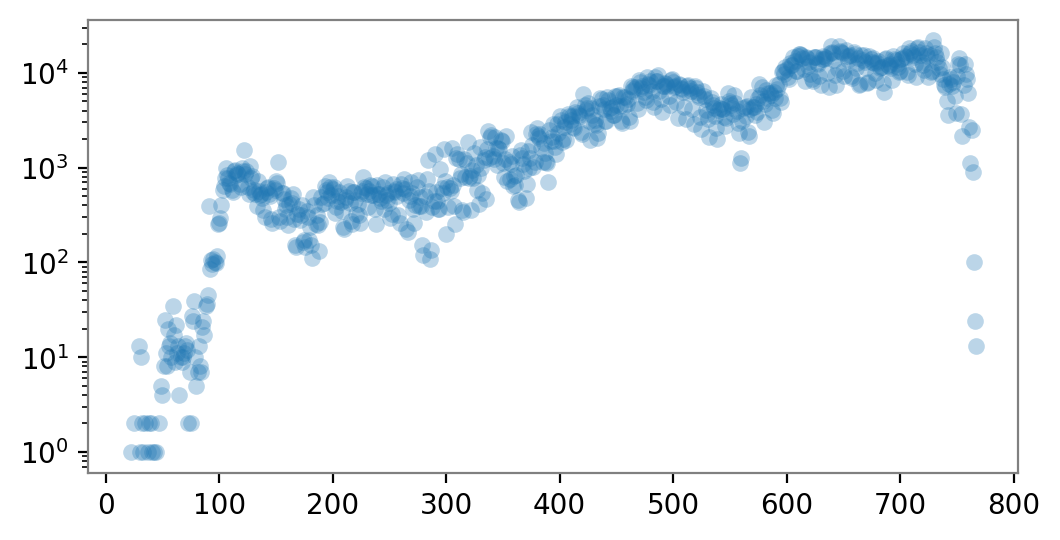

In [69]:
plt.figure(figsize=(6, 3))
plt.scatter(list(days.keys()), list(days.values()), lw=0, alpha=0.3)
plt.yscale("log")

## Comparison with the usher tree

In [10]:
from pyrocov.external.usher import parsimony_pb2
from Bio.Phylo.NewickIO import Parser, Writer

with open("results/usher/all.masked.pb", "rb") as f:
    proto = parsimony_pb2.data.FromString(f.read())
tree = next(Parser.from_string(proto.newick).parse())

In [9]:
dir(proto)

['ByteSize',
 'Clear',
 'ClearExtension',
 'ClearField',
 'CopyFrom',
 'DESCRIPTOR',
 'DiscardUnknownFields',
 'Extensions',
 'FindInitializationErrors',
 'FromString',
 'HasExtension',
 'HasField',
 'IsInitialized',
 'ListFields',
 'MergeFrom',
 'MergeFromString',
 'ParseFromString',
 'RegisterExtension',
 'SerializePartialToString',
 'SerializeToString',
 'SetInParent',
 'UnknownFields',
 'WhichOneof',
 '_CheckCalledFromGeneratedFile',
 '_SetListener',
 '__class__',
 '__deepcopy__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__unicode__',
 '_extensions_by_name',
 '_extensions_by_number',
 'condensed_nodes',
 'metadata',
 'newick',
 'node_mutations']

In [12]:
print(len(proto.condensed_nodes))
print(proto.condensed_nodes[:10])

438507
[node_name: "node_277374_condensed_9_leaves"
condensed_leaves: "Switzerland/LU-ETHZ-33951295/2021|OU727802.1|2021-09-01"
condensed_leaves: "Switzerland/LU-UHB-43030285/2021|OU736801.1|2021-08-30"
condensed_leaves: "Switzerland/LU-DIA-011423482501/2021|OU754404.1|2021-08-19"
condensed_leaves: "Switzerland/LU-UHB-43024430/2021|OU735359.1|2021-08-24"
condensed_leaves: "Switzerland/LU-DIA-011424149101/2021|OU754794.1|2021-08-28"
condensed_leaves: "Switzerland/LU-DIA-011424153001/2021|OU755170.1|2021-09-01"
condensed_leaves: "Switzerland/LU-DIA-011424150001/2021|OU755371.1|2021-08-30"
condensed_leaves: "Switzerland/LU-DIA-011424150401/2021|OU754379.1|2021-08-30"
condensed_leaves: "Switzerland/LU-UHB-43043568/2021|OU734798.1|2021-09-05"
, node_name: "node_238668_condensed_2_leaves"
condensed_leaves: "USA/TN-CDC-ASC210198292/2021|OK404919.1|2021-08-24"
condensed_leaves: "USA/TN-GD-090621-284/2021|OK162661.1|2021-08-27"
, node_name: "node_365383_condensed_3_leaves"
condensed_leaves: "En

In [13]:
strains = set(df2["strain"])

In [14]:
"Switzerland/LU-DIA-011424153001/2021|OU755170.1|2021-09-01" in strains

False

In [15]:
"Switzerland/LU-DIA-011424153001/2021" in strains

True

In [18]:
Counter(bool(node.name) for node in tree.find_clades())

Counter({False: 744501, True: 1671748})

## Phylogenetic distribution of samples in pruned trees

In [70]:
%%time
with open(f"results/columns.pkl", "rb") as f:
    columns = pickle.load(f)
clade_counts = {}
for max_num_clades in [2000, 3000, 5000, 10000]:
    filename = f"results/columns.{max_num_clades}.pkl"
    if os.path.exists(filename):
        with open(filename, "rb") as f:
            counts = Counter(pickle.load(f)["clade"])
            clade_counts[max_num_clades] = counts
            print((max_num_clades, len(counts)))

(2000, 1971)
(3000, 2970)
(5000, 4967)
(10000, 9945)
CPU times: user 6.6 s, sys: 4 s, total: 10.6 s
Wall time: 12.1 s


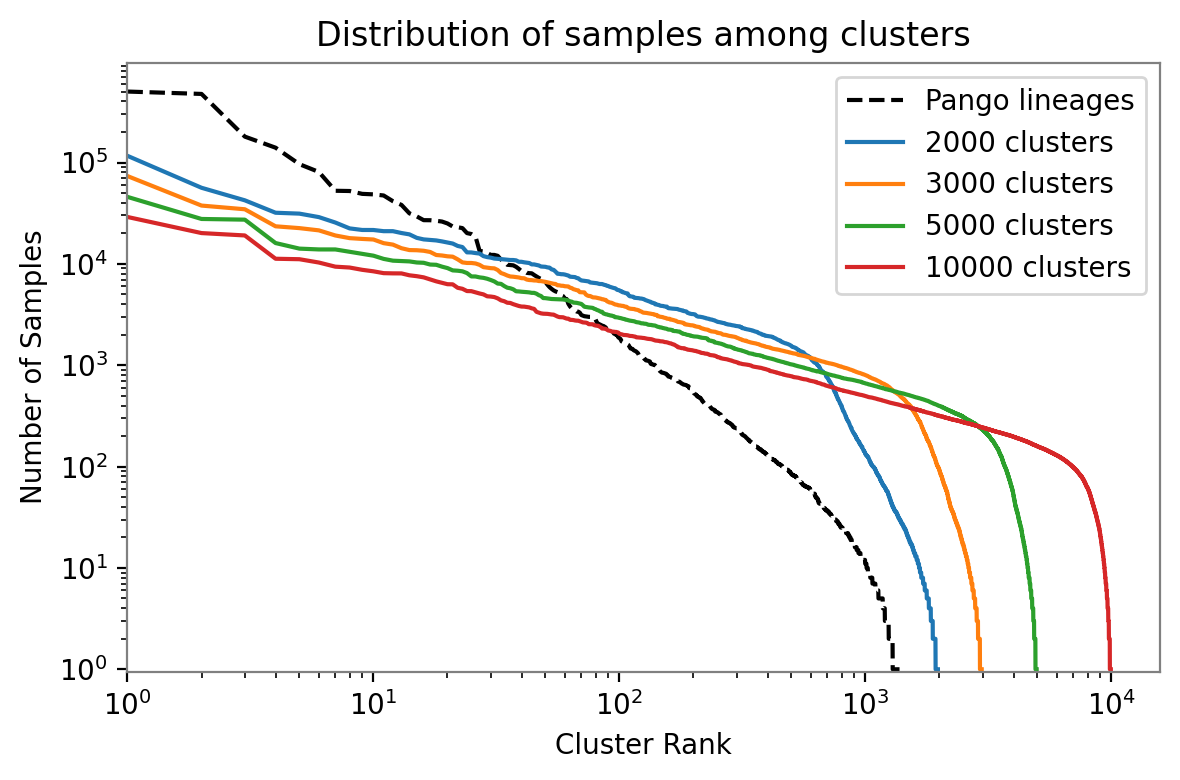

In [71]:
strain_counts = Counter(columns["lineage"])
plt.figure(figsize=(6,4))
Y = [c for _, c in strain_counts.most_common()]
plt.plot(torch.arange(1,1 + len(Y)), Y, "k--", label="Pango lineages")
for k, v in clade_counts.items():
    Y = [c for _, c in v.most_common()]
    plt.plot(torch.arange(1,1 + len(Y)), Y, label=f"{k} clusters")
plt.yscale("log")
plt.xscale("log")
plt.xlim(1, None)
plt.ylim(0.95, None)
plt.xlabel("Cluster Rank")
plt.ylabel("Number of Samples")
plt.legend(loc="upper right")
plt.title("Distribution of samples among clusters")
plt.tight_layout()
plt.savefig("paper/clade_distribution.png")

In [28]:
print({k: len(v) for k, v in clade_counts.items()})

{'full': 0, 2000: 1992, 5000: 0, 10000: 9986}


In [33]:
print({k: len(v) for k, v in columns.items()})

{'genbank_accession': 8, 'day': 2923152, 'location': 14, 'clade': 0, 'lineage': 0}


In [29]:
columns.keys()

dict_keys(['genbank_accession', 'day', 'location', 'clade', 'lineage'])

In [32]:
columns["day"][:10]

[186, 186, 186, 186, 186, 186, 186, 186, 186, 186]

In [41]:
with open("results/columns.2000.pkl", "rb") as f:
    columns2000 = pickle.load(f)

In [44]:
{k: len(v) for k, v in columns.items()}

{'genbank_accession': 2913523,
 'day': 2913523,
 'location': 2913523,
 'lineage': 2913523,
 'clade': 0}

In [43]:
{k: len(v) for k, v in columns2000.items()}

{'genbank_accession': 2913523,
 'day': 2913523,
 'location': 2913523,
 'lineage': 0,
 'clade': 0}

In [47]:
print(sum(1 for clade in tree.find_clades()))
print(sum(bool(clade.name) for clade in tree.find_clades()))

2416249
1671748


In [51]:
list(proto.condensed_nodes[0].condensed_leaves)

['Switzerland/LU-ETHZ-33951295/2021|OU727802.1|2021-09-01',
 'Switzerland/LU-UHB-43030285/2021|OU736801.1|2021-08-30',
 'Switzerland/LU-DIA-011423482501/2021|OU754404.1|2021-08-19',
 'Switzerland/LU-UHB-43024430/2021|OU735359.1|2021-08-24',
 'Switzerland/LU-DIA-011424149101/2021|OU754794.1|2021-08-28',
 'Switzerland/LU-DIA-011424153001/2021|OU755170.1|2021-09-01',
 'Switzerland/LU-DIA-011424150001/2021|OU755371.1|2021-08-30',
 'Switzerland/LU-DIA-011424150401/2021|OU754379.1|2021-08-30',
 'Switzerland/LU-UHB-43043568/2021|OU734798.1|2021-09-05']